### imports

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### collect and organize data

In [3]:
# import dataset 
data = np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')

# extract dat
labels = data[:,0]
data   = data[:,1:]

# normalize data
dataNorm = data / np.max(data)

# convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# convert into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

### shift image by few pixels in test loader

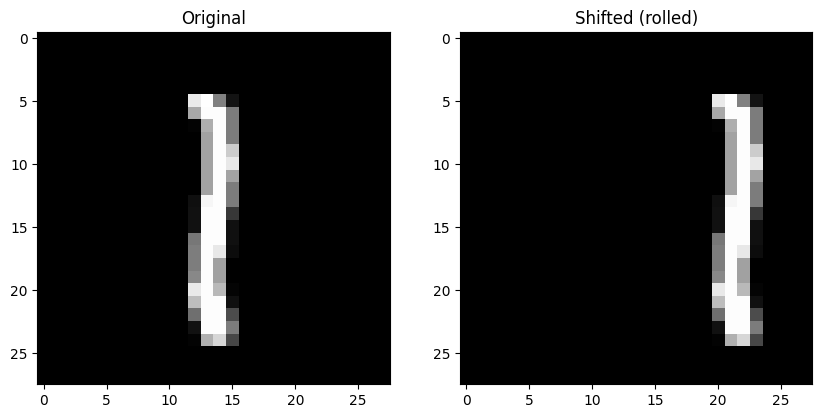

In [4]:
# grab one image data
tmp = test_loader.dataset.tensors[0][0, :]
tmp = tmp.reshape(28, 28)  # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp, 8, dims=1)


# now show them both
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(tmp, cmap="gray")
ax[0].set_title("Original")

ax[1].imshow(tmpS, cmap="gray")
ax[1].set_title("Shifted (rolled)")

plt.show()

In [5]:
# shift all the images in the test set
for i in range(test_loader.dataset.tensors[0].shape[0]):
    img = test_loader.dataset.tensors[0][i, :]
    randroll = np.random.randint(-10, 11)
    img = torch.roll(img.reshape(28, 28), randroll, dims=1)
    test_loader.dataset.tensors[0][i, :] = img.reshape(1, -1)

### ANN model

In [6]:
class mnistNet(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(784, 64)

        ### hidden layer
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 32)

        ### output layer
        self.output = nn.Linear(32, 10)

    # forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

### create_model function

In [7]:
def create_model():
    model = mnistNet()
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    return model, loss_function, optimizer

### train_model function

In [8]:
def train_model():

    numepochs = 50
    net, lossfun, optimizer = create_model()
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

        # average training accuracy and loss
        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        with torch.no_grad():  # deactivates autograd
            yHat = net(X)

        # store test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    return trainAcc, testAcc, losses, net

### run the model

In [9]:
trainAcc,testAcc,losses,net = train_model()

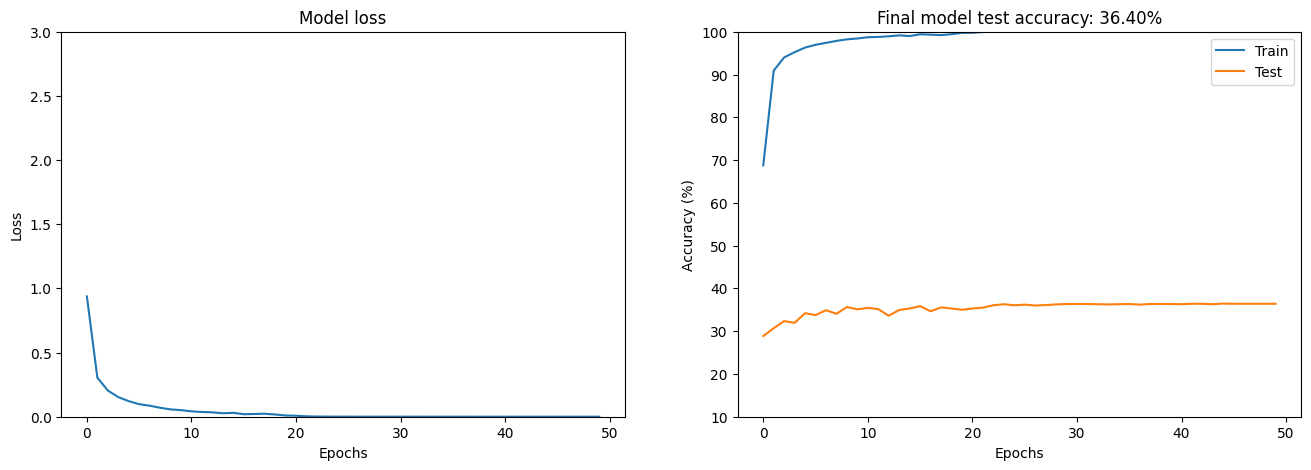

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()